In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

news_df=pd.read_csv('/content/gdrive/MyDrive/FS-Sem3/CompanyProject_RegHub/news_df_with_top4_signals.csv')
print(f"Length of raw dataframe = {len(news_df)}")
news_df.head(2)

Mounted at /content/gdrive
Length of raw dataframe = 3168


,id,news_date,news_title,news_content,companies_in_news,news_content_embeddings,signal_1,signal_2,signal_3,signal_4
0,maretBeatPresfiling20231003,2023-10-03T15:45:10.000Z,K.J. Harrison & Partners Inc Boosts Stake in C...,Deutsche Bank AG has acquired an additional 49...,"Berenberg Bank, Sartorius","tensor([ 8.2298e-03, -1.0426e-01, -1.6461e-02,...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Strategic_Steps_cos,Financial_Partnerships_cos
1,busTIMESPresesginvestingubs,2023-10-03T15:35:31.000Z,Conference aims to connect investors as ESG tr...,The UBS APAC Sustainable Finance Conference 20...,"Answer:\n\nBerenberg, Sebastian Bray","tensor([ 1.5170e-02, 7.4811e-02, -7.3396e-02,...",Financial_Partnerships_cos,Financial_Deals_cos,Capital_Markets_Stock_Analysis_cos,Technological_Deals_Collaborations_cos


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Capital_Markets_Stock_Analysis_cos'),
  Text(1, 0, 'Financial_Partnerships_cos'),
  Text(2, 0, 'Financial_Deals_cos'),
  Text(3, 0, 'Financial_Innovations_cos'),
  Text(4, 0, 'Strategic_Steps_cos'),
  Text(5, 0, 'Legal_Affairs_cos'),
  Text(6, 0, 'Regulatory_Actions_cos'),
  Text(7, 0, 'Financial_Health_cos'),
  Text(8, 0, 'Technological_Product_Launches_Innovations_cos'),
  Text(9, 0, 'Personnel_Change_cos'),
  Text(10, 0, 'Financial_Products_Services_cos'),
  Text(11, 0, 'Technological_Deals_Collaborations_cos')])

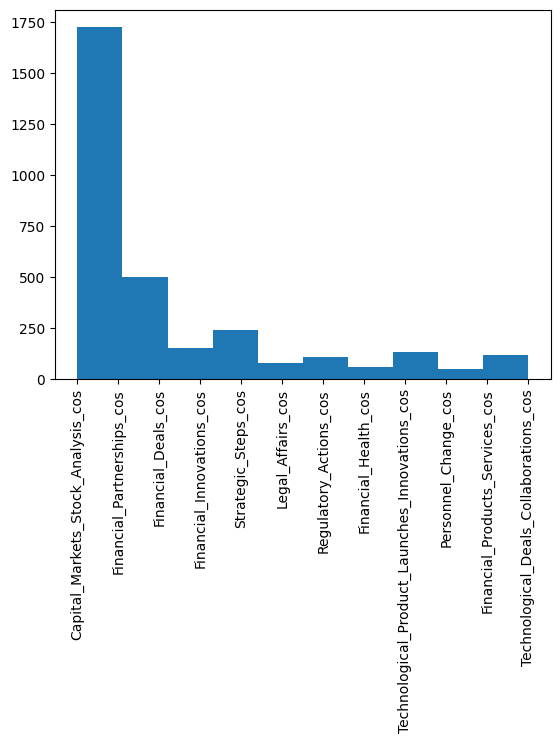

In [3]:
plt.hist(news_df['signal_1'])
plt.xticks(rotation=90)

In [4]:
%%capture
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [5]:
# our pre-defined dictionary of events/signals
event_descriptions = {
    "event": [
        "Financial_Products_Services",
        "Financial_Deals",
        "Financial_Partnerships",
        "Financial_Innovations",
        "Financial_Health",
        "Strategic_Steps",
        "Personnel_Change",
        "Technological_Product_Launches_Innovations",
        "Technological_Deals_Collaborations",
        "Regulatory_Actions",
        "Legal_Affairs",
        "Capital_Markets_Stock_Analysis"
    ],
    "description": [
        "News related to the introduction, withdrawal, or alterations in financial instruments, services, or products offered by a company. This includes launches, discontinuations, and changes in features.",
        "Reports covering financial transactions, such as the placement of new funds or assets in the capital market, as well as support for customer Initial Public Offerings (IPOs) or mergers and acquisitions.",
        "News highlighting collaborations, alliances, or partnerships entered into by a company for financial purposes. This can include joint ventures, strategic alliances, or long-term partnerships.",
        "News regarding the development and introduction of novel financial products or services, often accompanied by whitepapers or patents that showcase innovative approaches or technologies.",
        "Coverage related to the overall well-being of a company from a financial perspective. This encompasses aspects like bankruptcy, valuation changes, solvency issues, and other indicators of financial stability or distress.",
        "News outlining strategic decisions made by a company, such as initial public offerings (IPOs), mergers, acquisitions, expansions, fundraise activities, stock buybacks, and other significant corporate moves.",
        "Reports on changes in a company's workforce, including hirings, firings, the number of employees affected, mass recruitments, and any notable shifts in personnel.",
        "Information about the release of new technological products, services, or innovations. This category covers technological advancements, patents, and research papers hinting at potential tech developments.",
        "News highlighting partnerships, collaborations, or deals related to technology, including joint ventures, technology-sharing agreements, or collaborations for research and development.",
        "Reports on actions taken by or against a company by regulatory bodies. This includes compliance issues, regulatory investigations, and any changes in regulations affecting the company.",
        "News covering legal matters, including lawsuits, penalties, victories, sanctions, warnings, and other legal or compliance-related developments involving the company.",
        "Analyses and reports provided by companies, often banks, regarding stock performance, capital market trends, and insights into specific markets or assets."
    ]
}

events_df = pd.DataFrame(event_descriptions) # dataframe from dictionary
events_df['description_embeddings'] = ""

# re- creating embeddings of the descriptions of the signals
for index, row in events_df.iterrows():
  events_df.at[index, 'description_embeddings'] = model.encode(row['description'], convert_to_tensor=True)

events_df.head()

,event,description,description_embeddings
0,Financial_Products_Services,"News related to the introduction, withdrawal, ...","[tensor(0.0042, device='cuda:0'), tensor(0.016..."
1,Financial_Deals,"Reports covering financial transactions, such ...","[tensor(0.0492, device='cuda:0'), tensor(-0.03..."
2,Financial_Partnerships,"News highlighting collaborations, alliances, o...","[tensor(0.0351, device='cuda:0'), tensor(-0.05..."
3,Financial_Innovations,News regarding the development and introductio...,"[tensor(-0.0363, device='cuda:0'), tensor(-0.0..."
4,Financial_Health,Coverage related to the overall well-being of ...,"[tensor(0.0044, device='cuda:0'), tensor(0.092..."


In [6]:
company_of_interest = "Berenberg Bank" # company for which we want to analyze the news
signal_of_interest = "Capital_Markets_Stock_Analysis"


company_all_news_df = news_df[news_df['companies_in_news'].astype(str).str.contains(company_of_interest, case=False)]
company_all_news_df = company_all_news_df.sort_values(by='news_date', ascending = False)
company_news_df = company_all_news_df[company_all_news_df['signal_1'] == signal_of_interest + '_cos'].drop(columns=['signal_2', 'signal_3', 'signal_4']) # filtering news with signal_of_interest as signal_1
# extracting dates from date-time-stamps
company_news_df['news_date_simplified'] = pd.to_datetime(company_news_df['news_date'].str[:10]) # extract first 10 characters and convert to datetime
company_news_df = company_news_df.reset_index(drop=True)
print(f"length of filtered dataframe = {len(company_news_df)}")

cols = ['id', 'news_date',	'news_date_simplified', 'news_title',	'news_content',	'companies_in_news',	'news_content_embeddings',	'signal_1']
company_news_df = company_news_df[cols] #re-arranging columns
company_news_df.head(5)

length of filtered dataframe = 462


,id,news_date,news_date_simplified,news_title,news_content,companies_in_news,news_content_embeddings,signal_1
0,defWorldReporestupdate2html,2023-10-30 09:27:47,2023-10-30,Talanx AG (OTCMKTS:TNXXF) Short Interest Updat...,Berenberg Bank has upgraded its rating on Tala...,"Berenberg Bank, Talanx, HSBC.","tensor([-6.2445e-02, -5.9690e-02, -4.7869e-02,...",Capital_Markets_Stock_Analysis_cos
1,defyHSBCStocweredbyhsbchtml,2023-10-28 16:40:01,2023-10-28,Reckitt Benckiser Group (OTCMKTS:RBGLY) Stock ...,Berenberg Bank has reduced its target price fo...,"Reckitt Benckiser Group, Berenberg Bank.","tensor([ 3.4826e-02, -4.2792e-03, -7.7424e-03,...",Capital_Markets_Stock_Analysis_cos
2,abcshadowPresmideast104342444,2023-10-26 19:28:46,2023-10-26,Europe's central bank is set to halt rate hike...,The European Central Bank's (ECB) message appe...,"Berenberg bank, European Central Bank.","tensor([ 2.8340e-02, 2.0919e-02, -3.0415e-02,...",Capital_Markets_Stock_Analysis_cos
3,fin1023Presoverweight915798,2023-10-21 16:04:27,2023-10-21,MTU Aero Engines Overweight von JP Morgan Chas...,JP Morgan Chase & Co. has announced its plan t...,"JP Morgan Chase & Co, Berenberg Bank, Joh. Ber...","tensor([-1.3338e-02, 6.3491e-02, -2.3519e-02,...",Capital_Markets_Stock_Analysis_cos
4,efiareersJobk252Cny252Cusa,2023-10-21 05:59:26,2023-10-21,Investment Banking Analyst job in New York at ...,"The article is not accessible, however, it men...","Berenberg Bank, eFinancialCareers","tensor([ 3.0946e-02, -8.2079e-02, -8.6097e-02,...",Capital_Markets_Stock_Analysis_cos


In [7]:
random_row = 7
print(type(company_news_df.news_content_embeddings[random_row])) # this outputs type as string

# since "news_content_embeddings" column should contain tensors, we change the string items back to tensors
for index, row in company_news_df.iterrows():
  company_news_df.at[index, 'news_content_embeddings'] = model.encode(row['news_content'], convert_to_tensor=True)

print(type(company_news_df.news_content_embeddings[random_row])) # now this should be type 'tensor'

<class 'str'>
<class 'torch.Tensor'>


In [8]:
# now we evaluate news features in order to 'rank' news items

# feature 1 --> length of news item
company_news_df['news_length'] = company_news_df['news_content'].apply(lambda x: len(x.split()))  # word count as length
# feature 2 --> relevance of news item
company_news_df['news_relevance'] = company_news_df['news_content_embeddings'].apply(lambda x: util.pytorch_cos_sim(x, events_df.loc[events_df['event'] == signal_of_interest, 'description_embeddings'].iloc[0]).item())  # relevance = cosine similarity between 'news embedding' and 'signal/event descriprion'
# feature 3 --> age of news item
company_news_df['news_age'] = (datetime.now() - company_news_df['news_date_simplified']).dt.days + 1 # evaluating age of news in days

# filtering dataframe for latest 'n' days worth of news
n = 40
ndays_company_news_df = company_news_df[company_news_df['news_age']<=n]
print(len(ndays_company_news_df))
ndays_company_news_df.head()

6


,id,news_date,news_date_simplified,news_title,news_content,companies_in_news,news_content_embeddings,signal_1,news_length,news_relevance,news_age
0,defWorldReporestupdate2html,2023-10-30 09:27:47,2023-10-30,Talanx AG (OTCMKTS:TNXXF) Short Interest Updat...,Berenberg Bank has upgraded its rating on Tala...,"Berenberg Bank, Talanx, HSBC.","[tensor(-0.0624, device='cuda:0'), tensor(-0.0...",Capital_Markets_Stock_Analysis_cos,57,0.347074,28
1,defyHSBCStocweredbyhsbchtml,2023-10-28 16:40:01,2023-10-28,Reckitt Benckiser Group (OTCMKTS:RBGLY) Stock ...,Berenberg Bank has reduced its target price fo...,"Reckitt Benckiser Group, Berenberg Bank.","[tensor(0.0348, device='cuda:0'), tensor(-0.00...",Capital_Markets_Stock_Analysis_cos,29,0.135117,30
2,abcshadowPresmideast104342444,2023-10-26 19:28:46,2023-10-26,Europe's central bank is set to halt rate hike...,The European Central Bank's (ECB) message appe...,"Berenberg bank, European Central Bank.","[tensor(0.0283, device='cuda:0'), tensor(0.020...",Capital_Markets_Stock_Analysis_cos,86,0.304180,32
3,fin1023Presoverweight915798,2023-10-21 16:04:27,2023-10-21,MTU Aero Engines Overweight von JP Morgan Chas...,JP Morgan Chase & Co. has announced its plan t...,"JP Morgan Chase & Co, Berenberg Bank, Joh. Ber...","[tensor(-0.0133, device='cuda:0'), tensor(0.06...",Capital_Markets_Stock_Analysis_cos,96,0.336457,37
4,efiareersJobk252Cny252Cusa,2023-10-21 05:59:26,2023-10-21,Investment Banking Analyst job in New York at ...,"The article is not accessible, however, it men...","Berenberg Bank, eFinancialCareers","[tensor(0.0309, device='cuda:0'), tensor(-0.08...",Capital_Markets_Stock_Analysis_cos,30,0.404161,37


In [9]:
# now we combine features and 'rank' news items published in the latest n-days window:

# normalizing length for combining features
ndays_company_news_df['news_length_normalized'] = (ndays_company_news_df['news_length'] - ndays_company_news_df['news_length'].min()) / (ndays_company_news_df['news_length'].max() - ndays_company_news_df['news_length'].min())

# normalizing age for combining features; large age means less relevant news
ndays_company_news_df['news_age_normalized'] = 1 - ((ndays_company_news_df['news_age'] - ndays_company_news_df['news_age'].min()) / (ndays_company_news_df['news_age'].max() - ndays_company_news_df['news_age'].min()))

# combining features by assigning weights
weight_length = 0.3
weight_relevance = 0.6
weight_age = 1 - weight_length - weight_relevance
ndays_company_news_df['combined_feature'] = (weight_length * ndays_company_news_df['news_length_normalized']) + (weight_relevance * ndays_company_news_df['news_relevance']) + (weight_age * ndays_company_news_df['news_age_normalized'])

# assign rankings based on the final combined feature
ranked_ndays_company_news_df = ndays_company_news_df.sort_values(by='combined_feature', ascending=False)

ranked_ndays_company_news_df[['id', 'news_date', 'news_title', 'news_content', 'companies_in_news', 'signal_1', 'news_length', 'news_relevance', 'news_age', 'combined_feature']].head()

<ipython-input-9-075207374240>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndays_company_news_df['news_length_normalized'] = (ndays_company_news_df['news_length'] - ndays_company_news_df['news_length'].min()) / (ndays_company_news_df['news_length'].max() - ndays_company_news_df['news_length'].min())
<ipython-input-9-075207374240>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndays_company_news_df['news_age_normalized'] = 1 - ((ndays_company_news_df['news_age'] - ndays_company_news_df['news_age'].min

,id,news_date,news_title,news_content,companies_in_news,signal_1,news_length,news_relevance,news_age,combined_feature
3,fin1023Presoverweight915798,2023-10-21 16:04:27,MTU Aero Engines Overweight von JP Morgan Chas...,JP Morgan Chase & Co. has announced its plan t...,"JP Morgan Chase & Co, Berenberg Bank, Joh. Ber...",Capital_Markets_Stock_Analysis_cos,96,0.336457,37,0.511874
2,abcshadowPresmideast104342444,2023-10-26 19:28:46,Europe's central bank is set to halt rate hike...,The European Central Bank's (ECB) message appe...,"Berenberg bank, European Central Bank.",Capital_Markets_Stock_Analysis_cos,86,0.304180,32,0.497732
0,defWorldReporestupdate2html,2023-10-30 09:27:47,Talanx AG (OTCMKTS:TNXXF) Short Interest Updat...,Berenberg Bank has upgraded its rating on Tala...,"Berenberg Bank, Talanx, HSBC.",Capital_Markets_Stock_Analysis_cos,57,0.347074,28,0.433617
5,dirrviewsStocrgbank4121130347,2023-10-20 23:57:29,Greggs plc 54.1% potential upside indicated by...,Berenberg Bank has set a target price of 3550 ...,"Greggs plc, Berenberg Bank.",Capital_Markets_Stock_Analysis_cos,82,0.246388,38,0.385146
4,efiareersJobk252Cny252Cusa,2023-10-21 05:59:26,Investment Banking Analyst job in New York at ...,"The article is not accessible, however, it men...","Berenberg Bank, eFinancialCareers",Capital_Markets_Stock_Analysis_cos,30,0.404161,37,0.256974


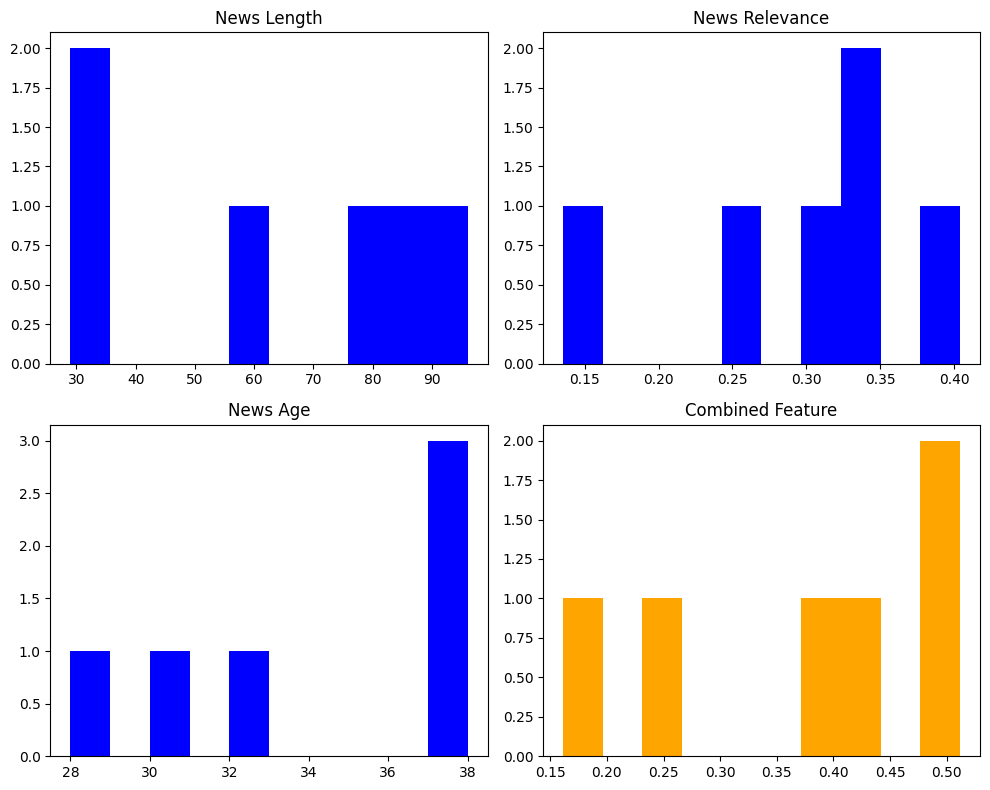

In [10]:
# plotting histograms in each subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axes[0, 0].hist(ranked_ndays_company_news_df['news_length'], color='blue')
axes[0, 0].set_title('News Length')

axes[0, 1].hist(ranked_ndays_company_news_df['news_relevance'], color='blue')
axes[0, 1].set_title('News Relevance')

axes[1, 0].hist(ranked_ndays_company_news_df['news_age'], color='blue')
axes[1, 0].set_title('News Age')

axes[1, 1].hist(ranked_ndays_company_news_df['combined_feature'], color='orange')
axes[1, 1].set_title('Combined Feature')

plt.tight_layout()
plt.show()

In [11]:
ranked_ndays_company_news_df = ranked_ndays_company_news_df.reset_index(drop=True)

number = 10
for index, row in ranked_ndays_company_news_df.head(number).iterrows():
    news_item = row['news_content']
    rank_score = row['combined_feature']
    print(f"{rank_score}: {news_item}")
    print("*****")

0.5118743515014649: JP Morgan Chase & Co. has announced its plan to acquire Joh. Berenberg Gossler & Co. KG, also known as Berenberg Bank. The German bank is well-known for its expertise in asset management and private banking. This acquisition is seen as a strategic move by JP Morgan to expand its presence in the European market. Berenberg Bank has a strong track record and a sizable client base, which will help JP Morgan strengthen its position and offer a wider range of services to European customers. The deal is expected to be completed on February 10, 2023.
*****
0.4977318604668574: The European Central Bank's (ECB) message appears to be clear, according to Holger Schmieding, the chief economist at Berenberg bank. In an analyst note, Schmieding highlighted that the ECB is not expected to make any significant changes to its policies at its upcoming meeting. The central bank is likely to maintain interest rates at their current record-low levels and continue its bond-buying program.